# Set up connection to WRDS

In [1]:
# pip install wrds #[Nov 30, Shravan] run once and comment out


In [2]:
# from google.colab import drive #[Dec 2, Shravan] run once and comment out
# drive.mount('/content/drive')
# shared_drive_path = '/content/drive/MyDrive/AFP/Code/'

In [3]:
import wrds
import pandas as pd
from datetime import datetime, timedelta,date
import os,psycopg2


conn = wrds.Connection()

# https://wrds-www.wharton.upenn.edu/data-dictionary/crsp_a_stock/dsf/
# https://wrds-www.wharton.upenn.edu/pages/about/data-vendors/sp-global-market-intelligence/
# https://wrds-www.wharton.upenn.edu/data-dictionary/crsp_a_stock/dsfhdr/

# # Database Schema

# # Query to get column names for optionm.opprcd2023
# query_opprcd = """
# SELECT column_name
# FROM information_schema.columns
# WHERE table_schema = 'optionm' AND table_name = 'opprcd2023';
# """

# # Query to get column names for optionm.secnmd
# query_secnmd = """
# SELECT column_name
# FROM information_schema.columns
# WHERE table_schema = 'optionm' AND table_name = 'secnmd';
# """

# # Execute queries
# columns_opprcd = conn.raw_sql(query_opprcd)
# columns_secnmd = conn.raw_sql(query_secnmd)

# print("Columns in optionm.opprcd2023:")
# print(columns_opprcd)
# print("\nColumns in optionm.secnmd:")
# print(columns_secnmd)

# # Get SIC codes

# table = 'opprcd'+ year

# # Define the SQL query to retrieve biotech stock data
# query = f"""
#     SELECT DISTINCT s.ticker, s.secid
#     FROM optionm.{table} o
#     JOIN optionm.secnmd s ON o.secid = s.secid
#     WHERE s.sic BETWEEN '2833' AND '2836'  -- SIC codes for biotech industry
#       AND o.date BETWEEN '{start_date}' AND '{end_date}'
#     ORDER BY s.ticker;
# """

# data = conn.raw_sql(query)

# # Display the first few rows of the fetched data
# data

# # Print the total number of biotech stocks
# #print(f"Total number of biotech stocks: {len(data)}")

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


# Set up inputs for tickers and dates

In [4]:
#path_tickers = os.path.join(shared_drive_path,r'Complete-List-of-Biotech-Stocks-Listed-on-NASDAQ-Jan-1-24.xlsx' ) #[Dec 2, Shravan] joining file name with directory as well
tickers_df = pd.read_excel(r"Complete-List-of-Biotech-Stocks-Listed-on-NASDAQ-Jan-1-24.xlsx")
tickers = tickers_df['Ticker'].unique().tolist()

# Define the dates
start_year = 2022
start_month = 11
start_day = 10

end_year = 2022
end_month = 12
end_day = 12

# Create start_date and end_date using datetime
start_date = datetime(start_year, start_month, start_day)
end_date = datetime(end_year, end_month, end_day)

# Generate list of years between the start and end date (inclusive)
years = list(range(start_date.year, end_date.year + 1))

# Print the start and end dates
print("Start Date:", start_date.strftime("%Y-%m-%d"))
print("End Date:", end_date.strftime("%Y-%m-%d"))


Start Date: 2022-11-10
End Date: 2022-12-12


# Pull Equities Data


In [5]:
# Function to get CUSIPs for tickers
def get_cusips(tickers):
    # Create a string of tickers in the form of ('ticker1', 'ticker2', ...)
    tickers_str = "('" + "','".join(tickers) + "')"

    query = f"""
        SELECT
             c.htsymbol, c.hcusip
        FROM
            crsp_a_stock.dsfhdr AS c
        WHERE
            c.htsymbol IN {tickers_str}
    """

    # Execute the query to get header data and return CUSIPs
    header = conn.raw_sql(query)

    # Remove rows with missing CUSIPs
    cusips = header.dropna()['hcusip'].unique().tolist()  # Ensure unique and drop NaN values
    return cusips


# Function to query daily stock data for a list of CUSIPs ; removed the final market cap filter
def query_daily_data(start_day: str, end_day: str, cusips: list):
    # Create a string for the CUSIPs list in the form of ('cusip1', 'cusip2', ...)
    cusips_str = "('" + "','".join(cusips) + "')"

    query = f"""
        SELECT
            c.cusip,
            b.ticker,  -- Use b.ticker instead of c.ticker
            c.date,
            c.bid,
            c.ask,
            c.vol,
            c.shrout, -- shares outstanding
            c.prc, -- price
            (c.prc * c.shrout) AS mktcap -- calculate market cap (price * shares outstanding)
        FROM
            crsp_a_stock.dsf AS c
        JOIN
            crsp_a_stock.dsenames AS b
        ON
            c.permno = b.permno
        WHERE
            c.date BETWEEN '{start_day}' AND '{end_day}'
            AND c.cusip IN {cusips_str}
            -- AND (c.prc * c.shrout) BETWEEN 100000 AND 5000000000  -- Filter using calculated market cap (Commented out this filter)
    """

    # Execute the query to get daily data for the provided CUSIPs
    data = conn.raw_sql(query)

    return data

# Get CUSIPs for the tickers
cusips = get_cusips(tickers)

# Query daily stock data for a specified date range and the obtained CUSIPs
equities_data = query_daily_data(start_date, end_date, cusips)

equities_data


,cusip,ticker,date,bid,ask,vol,shrout,prc,mktcap
0,75991610,RGEN,2022-11-10,188.89000,189.16000,641061.0,55524.0,189.16000,1.050292e+07
1,75991610,RGEN,2022-11-10,188.89000,189.16000,641061.0,55524.0,189.16000,1.050292e+07
2,75991610,RGEN,2022-11-10,188.89000,189.16000,641061.0,55524.0,189.16000,1.050292e+07
3,75991610,RGEN,2022-11-11,199.28999,199.42999,1024078.0,55524.0,199.28999,1.106538e+07
4,75991610,RGEN,2022-11-11,199.28999,199.42999,1024078.0,55524.0,199.28999,1.106538e+07
...,...,...,...,...,...,...,...,...,...
48864,21900C30,CRMD,2022-12-12,3.99000,4.00000,195628.0,41282.0,3.99000,1.647152e+05
48865,21900C30,CRMD,2022-12-12,3.99000,4.00000,195628.0,41282.0,3.99000,1.647152e+05
48866,21900C30,CRMD,2022-12-12,3.99000,4.00000,195628.0,41282.0,3.99000,1.647152e+05
48867,21900C30,CRMD,2022-12-12,3.99000,4.00000,195628.0,41282.0,3.99000,1.647152e+05


# Pull Options Data

In [6]:
def fetch_options_data(tickers, start_date, end_date, years):
    """
    Fetch options data for given tickers across multiple years with improved error handling
    and data validation.
    """
    all_options_data = []  # List to store concatenated results
    valid_data_found = False  # Flag to track if any valid data was found

    # Input validation
    if not tickers or not isinstance(tickers, list):
        raise ValueError("Tickers must be provided as a non-empty list")
    if not years or not isinstance(years, list):
        raise ValueError("Years must be provided as a non-empty list")

    # Loop over each year in the list
    for year in years:
        year_data = None
        try:
            table = 'opprcd' + str(year)
            # Create the SQL query with multiple tickers using IN clause
            tickers_str = "','".join(tickers)
            query = f"""
                SELECT o.date, s.ticker, o.exdate, o.cp_flag, o.strike_price,
                       o.best_bid, o.best_offer, o.volume, o.open_interest,
                       o.impl_volatility, o.delta, o.gamma, o.vega, o.theta
                FROM optionm.{table} o
                JOIN optionm.secnmd s ON o.secid = s.secid
                WHERE s.ticker IN ('{tickers_str}')
                  AND o.date BETWEEN '{start_date}' AND '{end_date}'
                ORDER BY o.date, s.ticker, o.exdate, o.strike_price;
            """

            # Execute the query
            year_data = conn.raw_sql(query)

            # Validate returned data
            if year_data is not None and isinstance(year_data, (list, pd.DataFrame)):
                if len(year_data) > 0:
                    # Check if data has the expected structure
                    expected_columns = ['date', 'ticker', 'exdate', 'cp_flag', 'strike_price',
                                     'best_bid', 'best_offer', 'volume', 'open_interest',
                                     'impl_volatility', 'delta', 'gamma', 'vega', 'theta']

                    if isinstance(year_data, pd.DataFrame):
                        if all(col in year_data.columns for col in expected_columns):
                            all_options_data.append(year_data)
                            valid_data_found = True
                            print(f"\nOptions data for year {year}:")
                            print(f"Total number of options contracts: {len(year_data)}")
                            print("\nSample of options data:")
                            print(year_data.head())  # Display first 5 records
                        else:
                            print(f"Warning: Data for year {year} has unexpected structure")
                    else:  # If it's a list
                        all_options_data.extend(year_data)
                        valid_data_found = True
                        print(f"\nOptions data for year {year}:")
                        print(f"Total number of options contracts: {len(year_data)}")
                        print("\nSample of options data:")
                        print(year_data[:5])  # Display first 5 records
                else:
                    print(f"No data found for year {year}")
            else:
                print(f"Invalid or empty data returned for year {year}")

        except pd.errors.EmptyDataError:
            print(f"No data available for year {year}")
        except (ValueError, AttributeError) as e:
            print(f"Data validation error for year {year}: {e}")
        except Exception as e:
            if "UndefinedTable" in str(e):
                print(f"Table for year {year} does not exist in the database")
            else:
                print(f"Error processing data for year {year}: {e}")

    # Final validation of concatenated data
    if not valid_data_found:
        print("\nWarning: No valid data was found for any year")
        return pd.DataFrame()  # Return empty DataFrame instead of None

    # Combine all data
    if all_options_data:
        if isinstance(all_options_data[0], pd.DataFrame):
            final_data = pd.concat(all_options_data, ignore_index=True)
        else:
            final_data = pd.DataFrame(all_options_data)

        # Display the overall summary
        print("\nOverall options data summary:")
        print(f"Total number of options contracts fetched: {len(final_data)}")
        return final_data
    else:
        return pd.DataFrame()  # Return empty DataFrame if no data

# Usage example:
try:
    options_data = fetch_options_data(tickers, start_date, end_date, years)
    if not options_data.empty:
        print("\nData fetched successfully")
    else:
        print("\nNo valid data was returned")
except Exception as e:
    print(f"Error in main execution: {e}")


Options data for year 2022:
Total number of options contracts: 3793386

Sample of options data:
         date ticker      exdate cp_flag  strike_price  best_bid  best_offer  \
0  2022-11-10   AADI  2022-11-18       P        2500.0       0.0         4.7   
1  2022-11-10   AADI  2022-11-18       C        2500.0      10.3        12.5   
2  2022-11-10   AADI  2022-11-18       C        2500.0      10.3        12.5   
3  2022-11-10   AADI  2022-11-18       P        2500.0       0.0         4.7   
4  2022-11-10   AADI  2022-11-18       P        5000.0       0.0         4.7   

   volume  open_interest  impl_volatility     delta     gamma      vega  \
0     0.0            0.0              NaN       NaN       NaN       NaN   
1     0.0            0.0         7.916858  0.979245  0.003117  0.101545   
2     0.0            0.0         7.916858  0.979245  0.003117  0.101545   
3     0.0            0.0              NaN       NaN       NaN       NaN   
4     0.0            0.0              NaN      

# Merge Equities and Options Data on Ticker and Date

In [7]:
# Convert date columns to datetime type for accurate merging
equities_data['date'] = pd.to_datetime(equities_data['date'])
options_data['date'] = pd.to_datetime(options_data['date'])

# Merging both datasets on 'ticker' and 'date'
merged_data = pd.merge(
    equities_data,
    options_data,
    on=['ticker', 'date'],
    how='inner'  # 'inner' merge to keep only rows that have a match in both datasets
)

# Display the merged data
merged_data.head()


,cusip,ticker,date,bid,ask,vol,shrout,prc,mktcap,exdate,...,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta
0,75991610,RGEN,2022-11-10,188.89,189.16,641061.0,55524.0,189.16,10502919.84,2022-11-18,...,75000.0,0.0,0.05,0.0,52.0,2.197427,-0.001313,0.00007,0.12127,-6.072884
1,75991610,RGEN,2022-11-10,188.89,189.16,641061.0,55524.0,189.16,10502919.84,2022-11-18,...,75000.0,111.7,116.50,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,75991610,RGEN,2022-11-10,188.89,189.16,641061.0,55524.0,189.16,10502919.84,2022-11-18,...,75000.0,0.0,0.05,0.0,52.0,2.197427,-0.001313,0.00007,0.12127,-6.072884
3,75991610,RGEN,2022-11-10,188.89,189.16,641061.0,55524.0,189.16,10502919.84,2022-11-18,...,75000.0,111.7,116.50,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,75991610,RGEN,2022-11-10,188.89,189.16,641061.0,55524.0,189.16,10502919.84,2022-11-18,...,75000.0,111.7,116.50,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [11]:
#equities_data.to_excel('equities_data.xlsx', index=False)
#options_data.to_excel('options_data.xlsx', index=False)
#merged_data.to_excel('merged_data.xlsx', index=False)

import sqlite3

# Assuming you already have the following DataFrames
# equities_data, options_data, merged_data

# Step 1: Create or connect to the SQLite database (it will be created if it doesn't exist)
conn = sqlite3.connect('financial_data.db')  # Creates the database file 'financial_data.db' if it doesn't exist

# Step 2: Write DataFrames to the SQLite database

# Write equities_data to a table called 'equities_data'
equities_data.to_sql('equities_data', conn, if_exists='replace', index=False)

# Write options_data to a table called 'options_data'
options_data.to_sql('options_data', conn, if_exists='replace', index=False)

# Write merged_data to a table called 'merged_data'
merged_data.to_sql('merged_data', conn, if_exists='replace', index=False)

# Step 3: Commit changes and close the connection
conn.commit()
conn.close()

print("Data has been written to the SQLite database successfully!")



Data has been written to the SQLite database successfully!


# RUN SIMPLE SAMPLE BACKTEST with backtrader

/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/empyrical/stats.py:1392: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/empyrical/stats.py:1392: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/empyrical/stats.py:1392: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error i

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1074.87,2021-02-24,2021-03-01,2021-03-05,8
1,993.88,2021-04-28,2021-04-29,2021-05-06,7
2,957.57,2021-06-08,2021-06-11,2021-06-14,5
3,945.21,2021-03-16,2021-03-18,2021-03-25,8
4,943.69,2021-06-15,2021-06-16,2021-06-21,5


/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/pyfolio/plotting.py:850: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  starting_value=is_cum_returns[-1],
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/pyfolio/plotting.py:850: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  starting_value=is_cum_returns[-1],
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of 

Stress Events,mean,min,max
Covid,351.25%,-28291.53%,333449.70%


Top 10 long positions of all time,max
Data0,95040.72%


Top 10 short positions of all time,max
Data0,-6891.95%


Top 10 positions of all time,max
Data0,95040.72%


/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/pyfolio/pos.py:100: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  longs = expos.where(expos.applymap(lambda x: x > 0))
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/pyfolio/pos.py:101: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shorts = expos.where(expos.applymap(lambda x: x < 0))
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/pyfolio/plotting.py:323: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_holdings_by_month = df_holdings.resample("1M").mean()
/Users/mukeshwaranbaskaran/anaconda3/envs/HW2/lib/python3.12/site-packages/pyfolio/plotting.py:1465: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_turnover_by_month = df_turnover.resample("M").mean()


Final Portfolio Value: $15170573.97


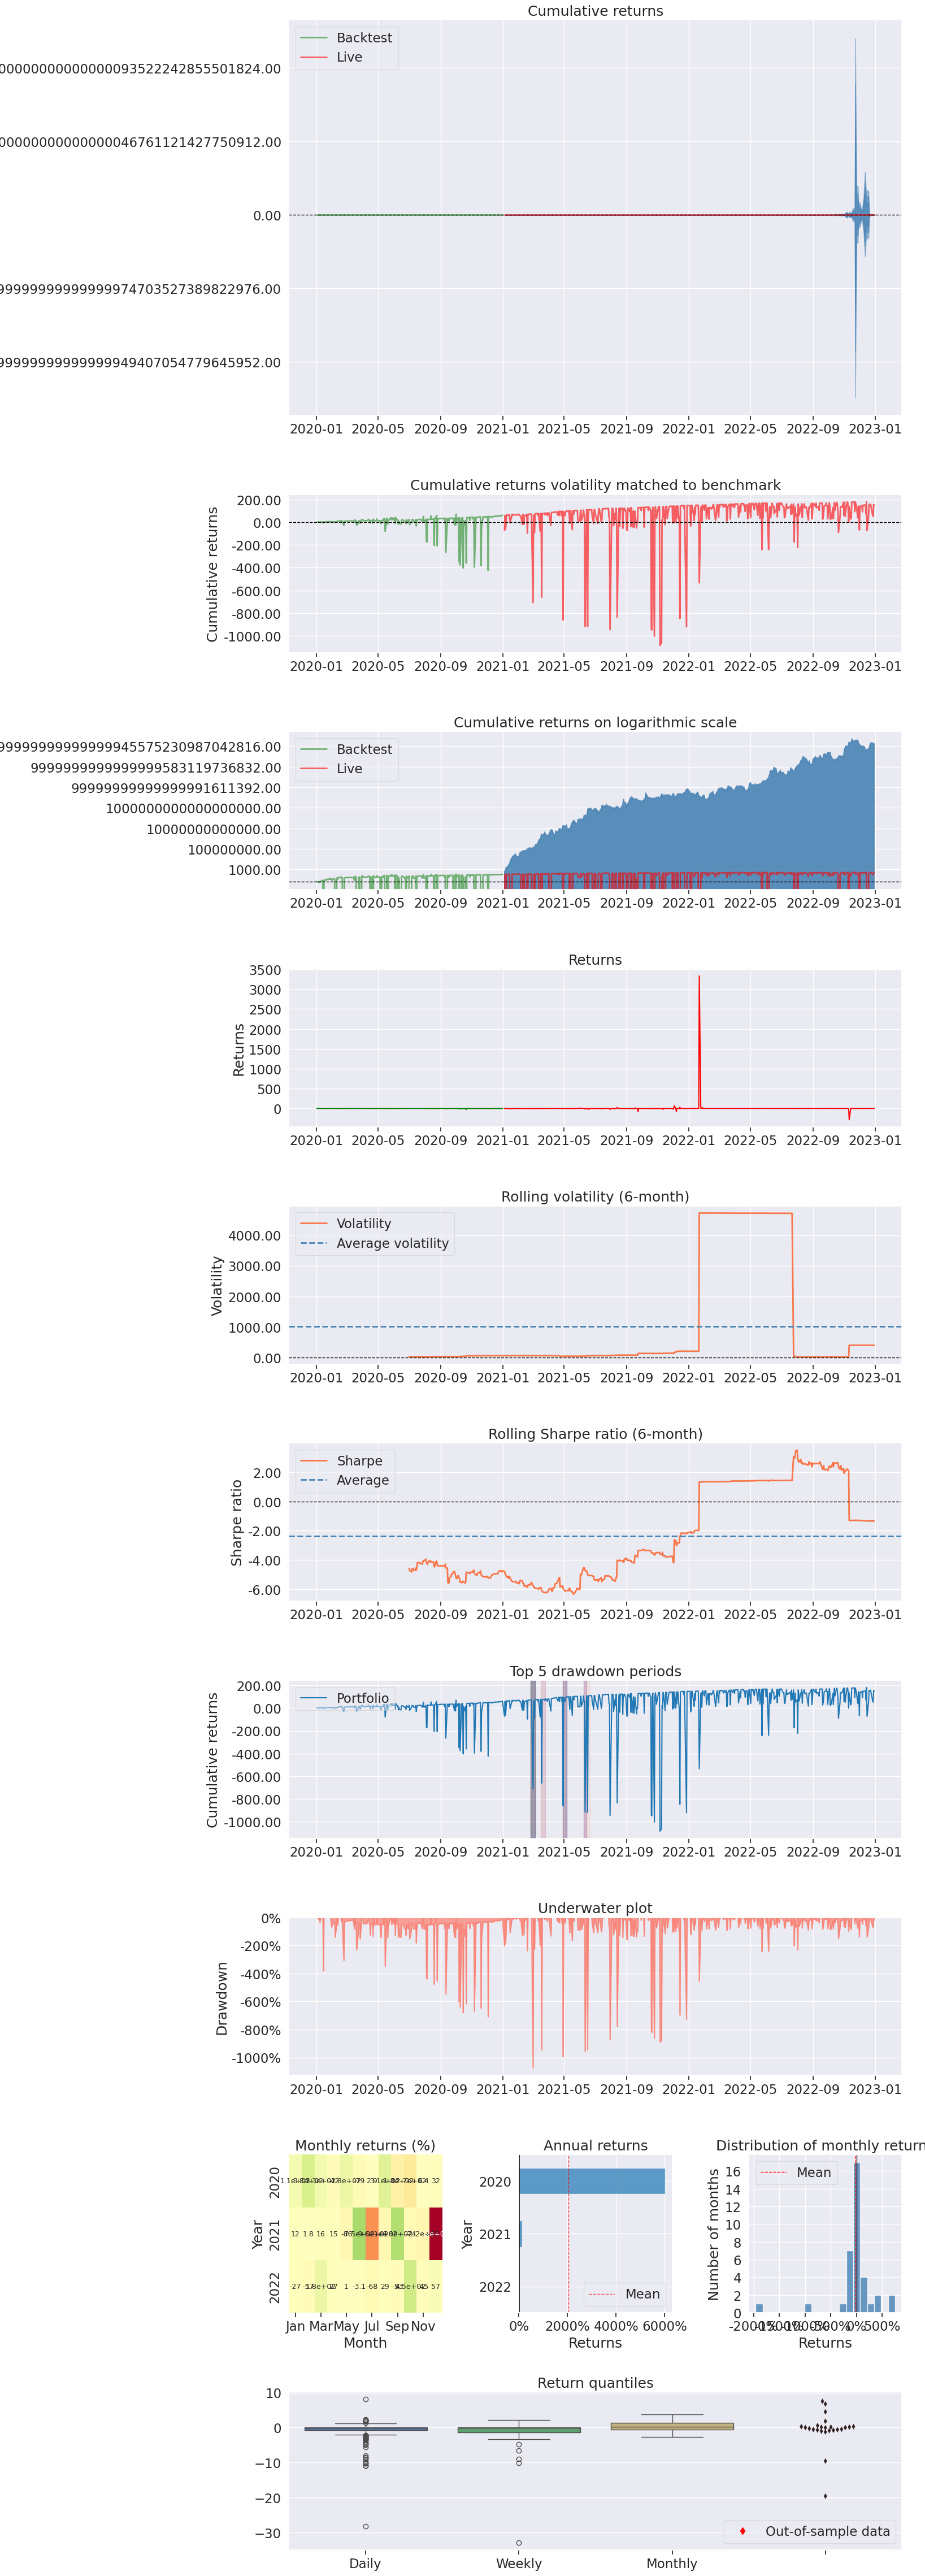

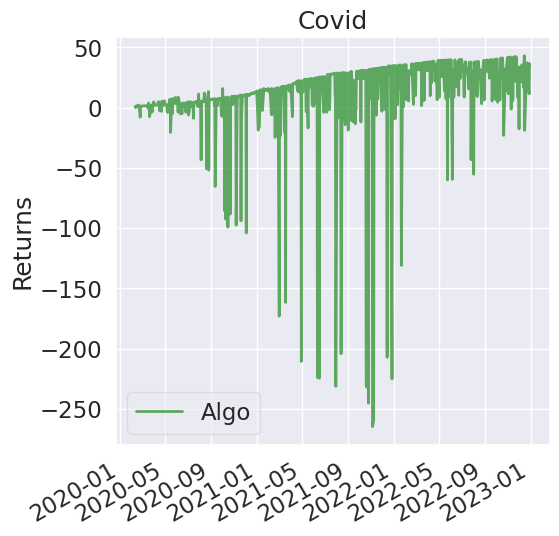

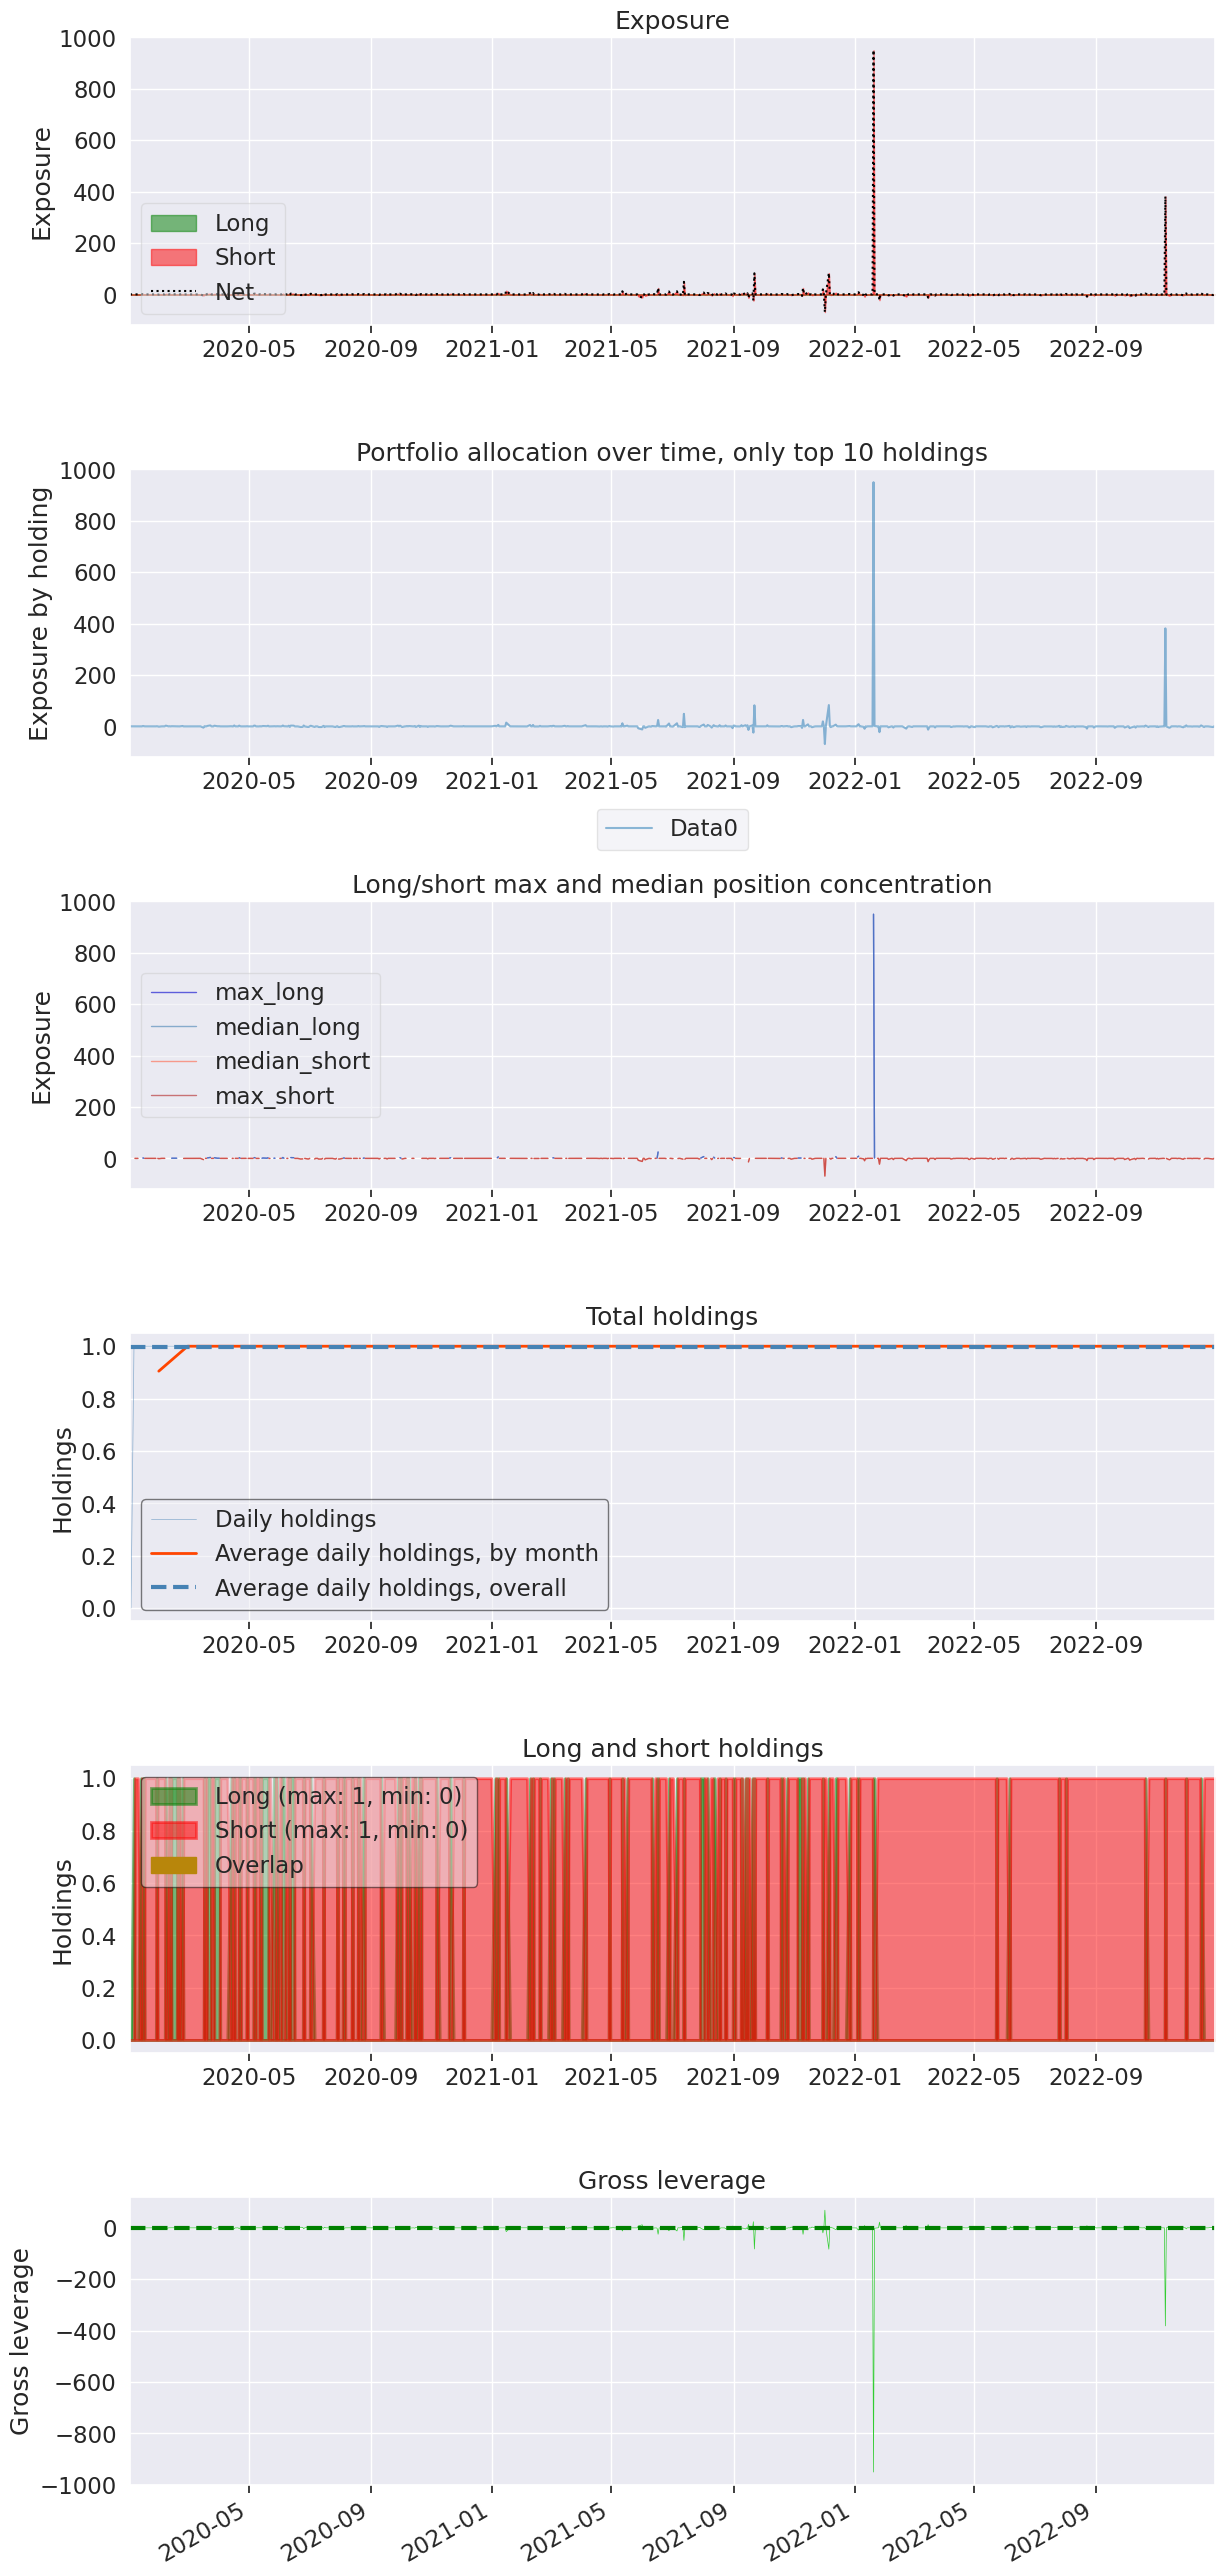

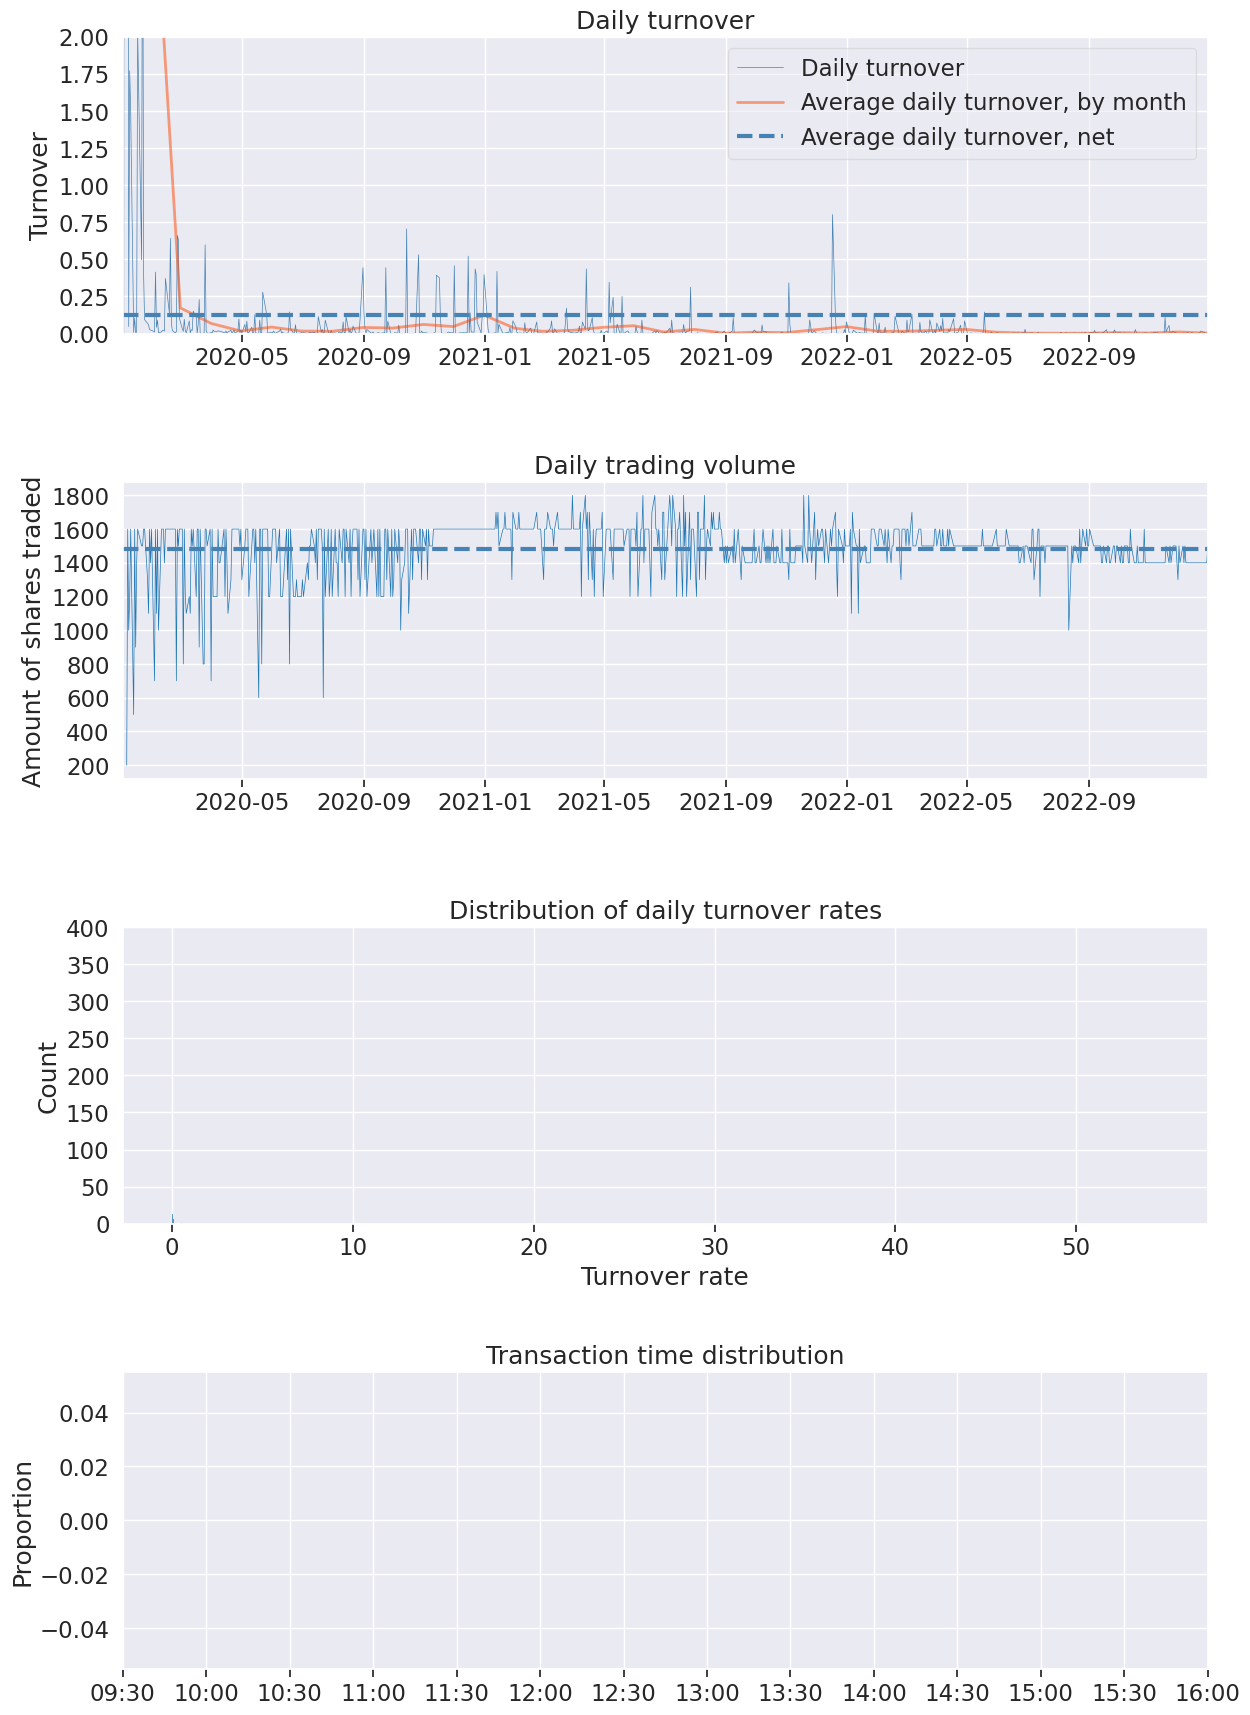

In [9]:
import backtrader as bt
import pandas as pd
import pyfolio as pf

# Define a function to prepare data
def prepare_data(start_date, end_date, tickers):
    cusips = get_cusips(tickers)
    equities_data = query_daily_data(start_date, end_date, cusips)
    df = pd.DataFrame(equities_data)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    df.ffill(inplace=True)
    return df

# Define a custom data feed class
class CustomDataFeed(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'bid'),
        ('high', 'ask'),
        ('low', 'bid'),
        ('close', 'prc'),
        ('volume', 'vol'),
        ('openinterest', None),
    )

# Define a simple moving average strategy
class SimpleStrategy(bt.Strategy):
    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=20)

    def next(self):
        if self.data.close[0] > self.sma[0] and not self.position:
            self.buy()
        elif self.data.close[0] < self.sma[0] and self.position:
            self.sell()

# Main function to run backtest
def run_backtest():
    cerebro = bt.Cerebro()
    cerebro.addstrategy(SimpleStrategy)

    # Prepare and add data feed
    start_date = '2020-01-01'
    end_date = '2022-12-31'
    tickers_bt = tickers[:10]
    df = prepare_data(start_date, end_date, tickers_bt)
    
    data_feed = CustomDataFeed(dataname=df)
    cerebro.adddata(data_feed)

    # Set broker parameters
    cerebro.broker.set_cash(100000)
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    
    # Run backtest
    results = cerebro.run()
    
    # Extract PyFolio results
    pyfolio_analyzer = results[0].analyzers.pyfolio
    pf_items = pyfolio_analyzer.get_pf_items()
    
    # Unpack PyFolio results
    returns, positions, transactions = pf_items[:3]
    
    # Generate performance tear sheet
    pf.create_full_tear_sheet(
        returns,
        positions=positions,
        transactions=transactions,
        live_start_date='2021-01-01'
    )
    
    print(f"Final Portfolio Value: ${cerebro.broker.getvalue():.2f}")

# Run the backtest
run_backtest()


# ALL TICKERS

In [10]:
# import backtrader as bt
# import pandas as pd
# import pyfolio as pf

# # Define a function to prepare data (with some added validation)
# def prepare_data(start_date, end_date, tickers):
#     """
#     Prepares the historical data for backtesting.
#     Args:
#         start_date (str): The start date of the backtest.
#         end_date (str): The end date of the backtest.
#         tickers (list): List of ticker symbols for which to query data.

#     Returns:
#         pd.DataFrame: Processed data ready for backtesting.
#     """
#     # Query the data for the tickers
#     cusips = get_cusips(tickers)  # Ensure get_cusips() returns the right identifiers
#     equities_data = query_daily_data(start_date, end_date, cusips)
    
#     # Convert data into a DataFrame and clean it up
#     df = pd.DataFrame(equities_data)
#     df['date'] = pd.to_datetime(df['date'])
#     df.set_index('date', inplace=True)
#     df.sort_index(inplace=True)
#     df.ffill(inplace=True)  # Forward fill any missing data points

#     return df

# # Define a custom data feed class to match the structure of your data
# class CustomDataFeed(bt.feeds.PandasData):
#     """
#     Custom Backtrader data feed to map the correct columns.
#     """
#     params = (
#         ('datetime', None),
#         ('open', 'bid'),
#         ('high', 'ask'),
#         ('low', 'bid'),
#         ('close', 'prc'),
#         ('volume', 'vol'),
#         ('openinterest', None),
#     )

# # Define a simple moving average crossover strategy
# class SimpleStrategy(bt.Strategy):
#     """
#     A simple moving average crossover strategy.
#     Buys when the price is above the moving average, sells when below.
#     """
#     def __init__(self):
#         self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=20)

#     def next(self):
#         if self.data.close[0] > self.sma[0] and not self.position:
#             self.buy()  # Buy signal
#         elif self.data.close[0] < self.sma[0] and self.position:
#             self.sell()  # Sell signal

# # Main function to run the backtest
# def run_backtest():
#     """
#     Run the backtest and generate a performance tear sheet using PyFolio.
#     """
#     cerebro = bt.Cerebro()
#     cerebro.addstrategy(SimpleStrategy)

#     # Prepare and add data feed
#     start_date = '2020-01-01'
#     end_date = '2022-12-31'
#     tickers_bt = tickers#[:10]  # Limit the tickers for this example
#     df = prepare_data(start_date, end_date, tickers_bt)

#     # Add data feed to Backtrader
#     data_feed = CustomDataFeed(dataname=df)
#     cerebro.adddata(data_feed)

#     # Set broker parameters
#     cerebro.broker.set_cash(100000)
#     cerebro.addsizer(bt.sizers.FixedSize, stake=100)

#     # Add PyFolio analyzer for performance tracking
#     cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

#     # Run the backtest
#     results = cerebro.run()
    
#     # Extract the PyFolio analyzer
#     pyfolio_analyzer = results[0].analyzers.pyfolio
#     pf_items = pyfolio_analyzer.get_pf_items()
    
#     # Unpack the results
#     returns, positions, transactions = pf_items[:3]

#     # Generate a PyFolio performance tear sheet
#     pf.create_full_tear_sheet(
#         returns,
#         positions=positions,
#         transactions=transactions,
#         live_start_date='2021-01-01'
#     )

#     # Print the final portfolio value
#     final_value = cerebro.broker.getvalue()
#     print(f"Final Portfolio Value: ${final_value:,.2f}")

# # Run the backtest
# if __name__ == "__main__":
#     run_backtest()
